In [3]:
from jax.config import config
config.update("jax_enable_x64", True)

import jax.numpy as jnp
import numpy as np
import pickle
from jax import jit
import jax.random as random
rng = random.PRNGKey(2022)
import jax.example_libraries.optimizers as optimizers
from jax.flatten_util import ravel_pytree

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("darkgrid")
cm = sns.color_palette("mako_r", as_cmap=True)
from scipy.stats import gaussian_kde
from scipy.stats import gamma, lognorm
import pandas as pd

from mat_models import MR, mn_sigma_vmap as mn_sigma
from utils_node import init_params, init_params_aniso, NODE_model, NODE_model_aniso
from utils import train_jp, eval_Cauchy, eval_Cauchy_aniso_vmap, merge_weights_aniso
from utils_diffusion import *

In [4]:
# Load the data
murine_data = pd.read_csv('data/murine_data.csv')
J = np.max(np.unique(murine_data.ID))

# Reduce the number of data points by prioritizing higher stretches
np.random.seed(2023)
def reduce_rows(df, stretch_column_1, stretch_column_2, keep_ratio):
    df_sorted = df.sort_values([stretch_column_1, stretch_column_2])
    num_rows = len(df_sorted)
    indices_to_keep = [df_sorted.index[0]] #Always keep the first point
    for i, row in df_sorted.iterrows():
        stretch_1 = row[stretch_column_1]
        stretch_2 = row[stretch_column_2]
        keep_prob = np.exp(keep_ratio * (stretch_1 + stretch_2 - 2.0))-1.0
        if np.random.uniform() < keep_prob:
            indices_to_keep.append(i)
    return df.loc[indices_to_keep]

keep_ratio = 1.2
murine_data = murine_data.groupby(['ID', 'test']).apply(reduce_rows, 'lm11', 'lm22', keep_ratio).reset_index(drop=True)

lamb_sigma_m = murine_data[['lm11', 'lm22', 'sigma11 (MPa)', 'sigma22 (MPa)']].to_numpy()
lamb_sigma_m = lamb_sigma_m[::10] #Reduce the number of points to help with training

In [5]:
lmbx_all, lmby_all, sgmx_all, sgmy_all = [], [], [], []
for i in np.unique(murine_data.ID):
    aux1, aux2, aux3, aux4 = murine_data[murine_data.ID==i][['lm11', 'lm22', 'sigma11 (MPa)', 'sigma22 (MPa)']].to_numpy().T
    lmbx_all.append(aux1)
    lmby_all.append(aux2)
    sgmx_all.append(aux3)
    sgmy_all.append(aux4)
lmbx_all = np.array(lmbx_all, dtype=object)
lmby_all = np.array(lmby_all, dtype=object)
sgmx_all = np.array(sgmx_all, dtype=object)
sgmy_all = np.array(sgmy_all, dtype=object)

lamb_sigma_m = murine_data[['lm11', 'lm22', 'sigma11 (MPa)', 'sigma22 (MPa)']].to_numpy()
lamb_sigma_m = lamb_sigma_m[::10] #Reduce the number of points to help with training

In [ ]:
# Normalization factors
I1_factor = 3.0
I2_factor = 3.0
Iv_factor = 1.0
Iw_factor = 1.0
normalization = [I1_factor, I2_factor, Iv_factor, Iw_factor]

# Define the loss function for when training all params
@jit
def loss_sig_all(params, lamb_sigma, normalization):
    model   = NODE_model_aniso(params, normalization)
    lambx   = lamb_sigma[:,0]
    lamby   = lamb_sigma[:,1]
    sigmax  = lamb_sigma[:,2]
    sigmay  = lamb_sigma[:,3]
    sigx,sigy = eval_Cauchy_aniso_vmap(lambx,lamby, model)
    return np.mean((sigx-sigmax)**2+(sigy-sigmay)**2)

# Initialize NODEs and the optimizer
key = random.PRNGKey(0)
common_layers = [1, 5, 5]
sample_layers = [5,1]
params_all = init_params_aniso(common_layers, sample_layers, key)
opt_init, opt_update, get_params = optimizers.adam(5.e-4) #Original: 1.e-4
opt_state = opt_init(params_all)

# Train
params_all, train_loss, val_loss = train_jp(loss_sig_all, lamb_sigma_m, normalization, get_params, opt_update, opt_state, key, nIter = 50000, print_freq=10000)
with open('params/mice_node_params_all.npy', 'wb') as f:
    pickle.dump(params_all, f)

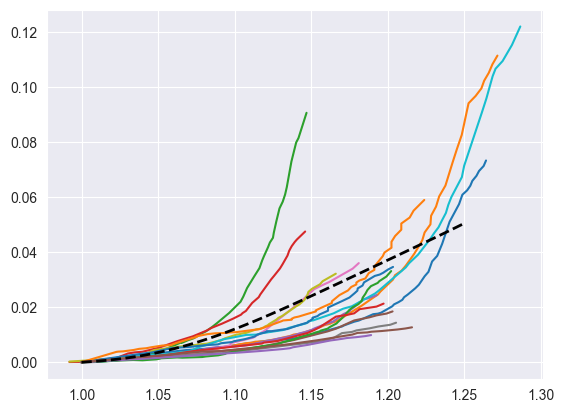

In [6]:
# Plot all the equibiaxial data
for i in np.unique(murine_data.ID):
    data_i = murine_data[(murine_data.ID==i)&(murine_data.test==2)]
    plt.plot(data_i.lm11, data_i['sigma11 (MPa)'])

# Plot model predictions
lmb = np.linspace(1,1.25)
mymodel = NODE_model_aniso(params_all, normalization)
sgmx,sgmy = eval_Cauchy_aniso_vmap(lmb,lmb, mymodel)
plt.plot(lmb, sgmx, 'k--', linewidth=2)

In [7]:
# fit individually 
NODE_weights, theta, Psi1_bias, Psi2_bias, alpha = params_all
params_I1, params_I2, params_1_v, params_1_w, params_v_w = NODE_weights
params_I1c,params_I1s = params_I1
params_I2c,params_I2s = params_I2
params_1_vc,params_1_vs = params_1_v
params_1_wc,params_1_ws = params_1_w
params_v_wc,params_v_ws = params_v_w

def loss_sample(sample_params, X, normalization): #This keeps the common params constant and varies sample_params
    params = merge_weights_aniso(params_all, sample_params)
    return loss_sig_all(params, X, normalization)

mean_sample_params = (params_I1s, params_I2s, params_1_vs, params_1_ws, params_v_ws, theta, Psi1_bias, Psi2_bias, alpha)

Sample_params = []

for j in range(J):
    lamb_sigma_j = murine_data[murine_data.ID==j][['lm11', 'lm22', 'sigma11 (MPa)', 'sigma22 (MPa)']].to_numpy()
    opt_init, opt_update, get_params = optimizers.adam(5.0e-4)
    opt_state = opt_init(mean_sample_params)

    sample_params, train_loss, val_loss = train_jp(loss_sample, lamb_sigma_j, normalization, get_params, opt_update, opt_state, key, nIter = 20000, print_freq=20000)
    Sample_params.append(sample_params)

with open('params/mice_node_sample_params.npy', 'wb') as f:
    pickle.dump(Sample_params, f)

it 20000, train loss = 3.129546e-05
it 20000, train loss = 4.272184e-05
it 20000, train loss = 5.960647e-04
it 20000, train loss = 2.241887e-04
it 20000, train loss = 3.713386e-05
it 20000, train loss = 2.992398e-05
it 20000, train loss = 2.105238e-04
it 20000, train loss = 2.988910e-05
it 20000, train loss = 2.408493e-04
it 20000, train loss = 9.902085e-04
it 20000, train loss = 1.306347e-04
it 20000, train loss = 2.068709e-04
it 20000, train loss = 2.006958e-04
it 20000, train loss = 4.000619e-05
it 20000, train loss = 2.779975e-06


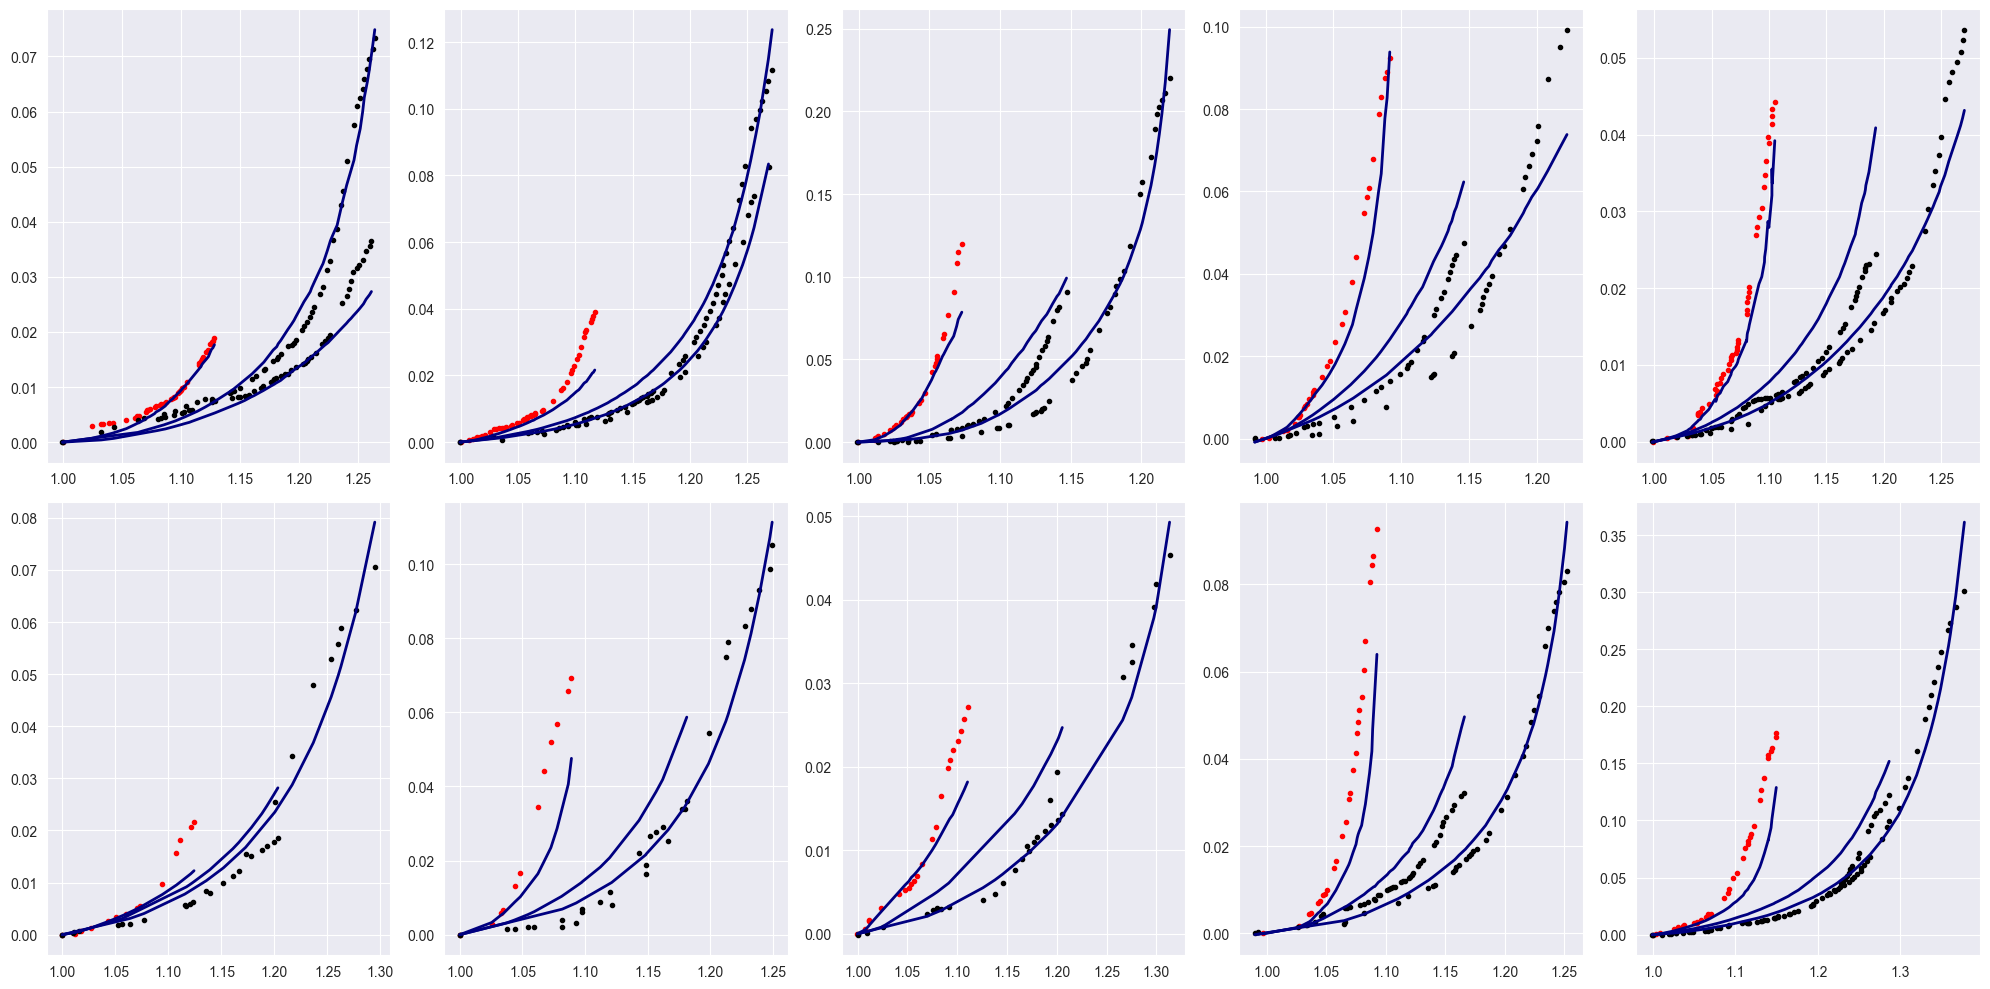

In [8]:
plt.figure(figsize = (20,10))
for i, sample_params in enumerate(Sample_params[:10]): #plot the first 10
    plt.subplot(2,5,i+1)

    data_i_offx = murine_data[(murine_data.ID==i)&(murine_data.test==0)]
    data_i_offy = murine_data[(murine_data.ID==i)&(murine_data.test==1)]
    data_i_equi = murine_data[(murine_data.ID==i)&(murine_data.test==2)]
    plt.plot(data_i_offx['lm11'], data_i_offx['sigma11 (MPa)'], 'r.',linewidth=2)
    plt.plot(data_i_offy['lm11'], data_i_offy['sigma11 (MPa)'], 'k.',linewidth=2)
    plt.plot(data_i_equi['lm11'], data_i_equi['sigma11 (MPa)'], 'k.',linewidth=2)

    params = merge_weights_aniso(params_all, sample_params)
    mymodel = NODE_model_aniso(params, normalization)
    sigx_offx,sigy_offx = eval_Cauchy_aniso_vmap(data_i_offx['lm11'].to_numpy(),data_i_offx['lm22'].to_numpy(), mymodel)
    sigx_offy,sigy_offy = eval_Cauchy_aniso_vmap(data_i_offy['lm11'].to_numpy(),data_i_offy['lm22'].to_numpy(), mymodel)
    sigx_equi,sigy_equi = eval_Cauchy_aniso_vmap(data_i_equi['lm11'].to_numpy(),data_i_equi['lm22'].to_numpy(), mymodel)
    plt.plot(data_i_offx['lm11'], sigx_offx, color='navy', linewidth=2)
    plt.plot(data_i_offy['lm11'], sigx_offy, color='navy', linewidth=2)
    plt.plot(data_i_equi['lm11'], sigx_equi, color='navy', linewidth=2)

plt.tight_layout()

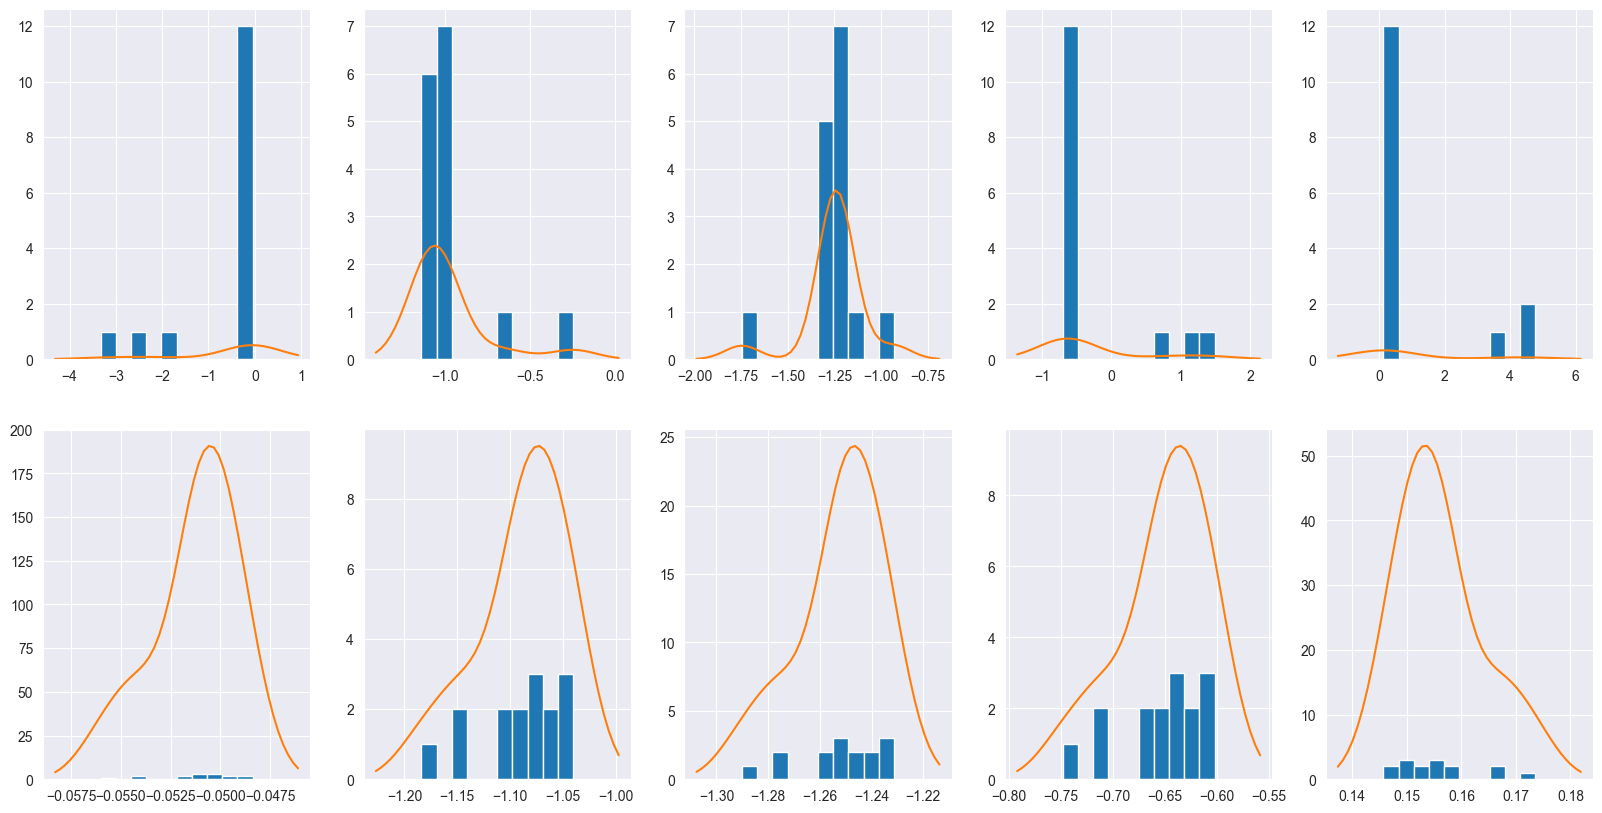

In [54]:
ws = np.array([ravel_pytree(sample_params)[0] for sample_params in Sample_params])
template, unravel_params = ravel_pytree(Sample_params[0])

plt.figure(figsize = (20,10))
kernels = []
for i, w in enumerate(ws.T):
    kernel = gaussian_kde(w)
    kernels.append(kernel)

    if i < 10:
        plt.subplot(2,5,i+1)
        plt.hist(w)
        xmin = np.min(w)
        xmax = np.max(w)
        r = xmax-xmin
        x = np.linspace(xmin - 0.3*r, xmax + 0.3*r)
        y = kernel(x)
        plt.plot(x,y)

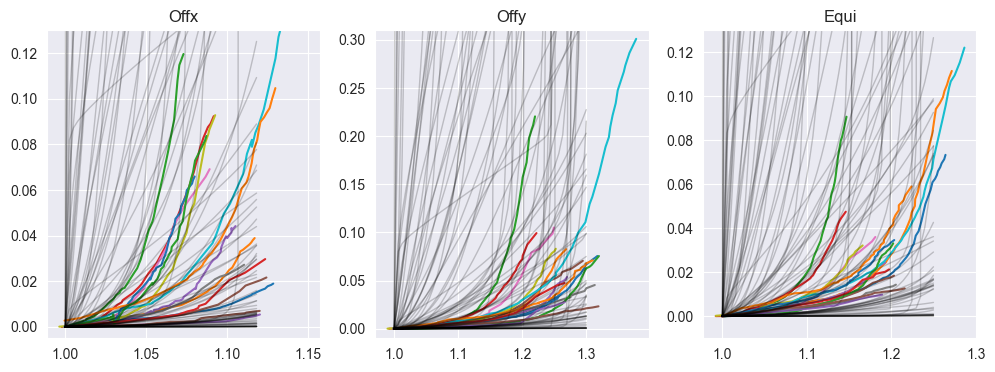

In [55]:
template = np.array(template)

# Try new samples from these distributions
fig, axs = plt.subplots(ncols=3, nrows=1, figsize=(12,4))
axs[0].set(ylim=[-0.005, 0.13], title='Offx')
axs[1].set(ylim=[ -0.01, 0.31], title='Offy')
axs[2].set(ylim=[ -0.01, 0.13], title='Equi')

# Plot the data
for t in range(3):
  for i in np.unique(murine_data.ID):
      data_i = murine_data[(murine_data.ID==i)&(murine_data.test==t)]
      axs[t].plot(data_i.lm11, data_i['sigma11 (MPa)'])

for i in range(100):
    for j, kernel in enumerate(kernels):
        template[j] = kernel.resample(1)
    sample_params = unravel_params(template)
    
    params = merge_weights_aniso(params_all, sample_params)
    mymodel = NODE_model_aniso(params, normalization)
    lmbx = np.linspace(1,1.25) 
    sigx,sigy = eval_Cauchy_aniso_vmap(np.sqrt(lmbx),lmbx, mymodel) # Offx
    axs[0].plot(np.sqrt(lmbx),       sigx,      color='k',linewidth=1,alpha=0.2)

    lmbx = np.linspace(1,1.3) 
    sigx,sigy = eval_Cauchy_aniso_vmap(lmbx,np.sqrt(lmbx), mymodel) # Offy
    axs[1].plot(lmbx,       sigx,      color='k',linewidth=1,alpha=0.2)

    lmbx = np.linspace(1,1.25) 
    sigx,sigy = eval_Cauchy_aniso_vmap(lmbx,lmbx, mymodel) # Equibi
    axs[2].plot(lmbx,       sigx,      color='k',linewidth=1,alpha=0.2)